In [1]:
%%capture
from stylometry import *

from keras.models import Model
from keras.layers import  Activation, Dense, Input
from keras.optimizers import RMSprop
from sklearn.utils import shuffle

In [2]:
# download two books from project gutenberg for discrimination task
!mkdir books
!wget https://www.gutenberg.org/cache/epub/3623/pg3623.txt -O books/golden_bough.txt
!wget https://www.gutenberg.org/files/17087/17087-0.txt -O books/art_and_ritual.txt

--2021-01-20 15:43:31--  https://www.gutenberg.org/cache/epub/3623/pg3623.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2326536 (2.2M) [text/plain]
Saving to: ‘books/golden_bough.txt’

books/golden_bough. 100%[===================>]   2.22M  3.02MB/s    in 0.7s    

2021-01-20 15:43:32 (3.02 MB/s) - ‘books/golden_bough.txt’ saved [2326536/2326536]

--2021-01-20 15:43:32--  https://www.gutenberg.org/files/17087/17087-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 306671 (299K) [text/plain]
Saving to: ‘17087-0.txt.3’

17087-0.txt.3       100%[===================>] 299.48K  1.28MB/s    in 0.2s    

2021-

In [3]:
# prepare book text
with open('books/art_and_ritual.txt') as f:
    corpus_a = f.read()
with open('books/golden_bough.txt') as f:
    corpus_g = f.read()
    
corpus_a = clean(corpus_a)
corpus_g = clean(corpus_g)

# split last tenth of each book for test data
corpus_a_test = corpus_a[int(.9*len(corpus_a)):]
corpus_g_test = corpus_g[int(.9*len(corpus_g)):]
corpus_a = corpus_a[:int(.9*len(corpus_a))]
corpus_g = corpus_g[:int(.9*len(corpus_g))]

In [4]:
%%time
# generate samples from books
num_samps = 1000
len_samps = 1000
num_samps_test = 100
num_features = 500

la = len(corpus_a)
lg = len(corpus_g)

bag_a = [corpus_a[k:k+len_samps] for k in 
          np.random.randint(0,la-len_samps,num_samps)]
bag_g = [corpus_g[k:k+len_samps] for k in 
          np.random.randint(0,lg-len_samps,num_samps)]

# generate features from samples
words_a = ' '.join(bag_a).split()
words_g = ' '.join(bag_g).split()
words_a += bigrams(words_a)
words_g += bigrams(words_g)

features = generate_features_from_words(words_a,words_g, 
                                        num_features)

#features_bi = generate_features_from_words(bigrams(words_a),
#                                         bigrams(words_g),
#                                         num_features)

#features = list(itertools.chain(*zip(features,features_bi)))

# generate test samples
lat = len(corpus_a_test)
lgt = len(corpus_g_test)

bag_at = [corpus_a_test[k:k+len_samps] for k in 
          np.random.randint(0,lat-len_samps,num_samps_test)]
bag_gt = [corpus_g_test[k:k+len_samps] for k in 
          np.random.randint(0,lgt-len_samps,num_samps_test)]


# print top stylometric features
print(' | '.join(features[:20]+['...']+features[-20:]))

the | to | of | of the | in | which | by | on | who | his | in the | corn | their | to the | them | on the | king | with | been | him | ... | spring | is the | only | dance | what | greek | it is | us | our | this | that | life | it | and | ritual | not | but | art | we | is
CPU times: user 280 ms, sys: 20.2 ms, total: 300 ms
Wall time: 298 ms


In [5]:
# visualize how a snippet gets evaluated
fext = bag_a[5]
fext = colorize(fext,features[:num_features][::-1],'red')
fext = colorize(fext,features[num_features:][::-1],'green')
print(fext)

e make a fog the dreaded terror of the sea all the more terrifying because of its very silence and gentleness for the expert seafarer no less than the ignorant landsman nevertheless a fog at sea can be a source of intense relish and enjoyment abstract from the experience of the sea fog for the moment its danger and practical unpleasantness direct the attention to the features objectively constituting the phenomena the veil surrounding you with an opaqueness as of transparent milk blurring the outlines of things and distorting their shapes into weird grotesqueness observe the carrying power of the air producing the impression as if you could touch some far off siren by merely putting out your hand and letting it lose itself behind that white wall note the curious creamy smoothness of the water hypercritically denying as it were any suggestion of danger and above all the strange solitude and remoteness from the world as it can be found only on the highest mountain tops and the experience

test accuracy: 0.9
CPU times: user 2.93 s, sys: 6.04 ms, total: 2.94 s
Wall time: 2.94 s


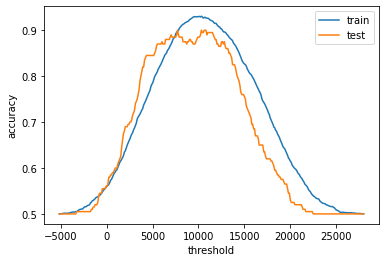

In [6]:
%%time
# unsupervised naive method

naive_scores_a = naive_score(bag_a,features)
naive_scores_g = naive_score(bag_g,features)

naive_scores_at = naive_score(bag_at,features)
naive_scores_gt = naive_score(bag_gt,features)

NS = [(k,(np.mean(naive_scores_a<k)+\
          np.mean(naive_scores_g>=k))/2)
 for k in np.arange(int(min(naive_scores_a)),
            int(max(naive_scores_g)),100)]

NS_test = [(k,(np.mean(naive_scores_at<k)+\
          np.mean(naive_scores_gt>=k))/2)
 for k in np.arange(int(min(naive_scores_a)),
            int(max(naive_scores_g)),100)]

plt.plot([n[0] for n in NS],[n[1] for n in NS],label='train')
plt.plot([n[0] for n in NS_test],[n[1] for n in NS_test],label='test')
plt.ylabel('accuracy')
plt.xlabel('threshold')
plt.legend()
print('test accuracy:',NS_test[np.argmax([n[1] for n in NS])][1])

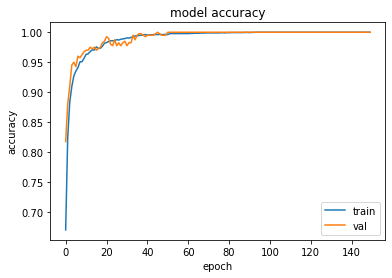

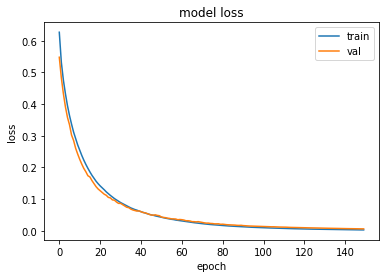

test accuracy: 0.96
CPU times: user 7.94 s, sys: 1.44 s, total: 9.39 s
Wall time: 6.04 s


In [7]:
%%time
# train single dense layer
# create feature vectors
X_train = np.array([[int(f in b) for f in features] 
                    for b in bag_a + bag_g])

y_train = np.array([[0,1] for i in bag_a]+[[1,0] for i in bag_g])

X_test = np.array([[int(f in b) for f in features] 
                    for b in bag_at + bag_gt])

y_test = np.array([1 for i in bag_at]+[0 for i in bag_gt])

X_train, y_train = shuffle(X_train,y_train,random_state=1305)


def sdl(in_size,out_size):
    inputs = Input(name='inputs',shape=[in_size])
    layer = Dense(out_size)(inputs)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

model = sdl(X_train.shape[1],2)

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(X_train,y_train,batch_size=256,epochs=150,
          validation_split=0.1,verbose=0)
y_pred = np.argmax(model.predict(X_test),axis=1)
history_plot(history)
print('test accuracy:',np.mean(y_test==y_pred))

In [8]:
%%time
%%capture
# compare with bert

import torch
#from transformers import AutoTokenizer, AutoModel
#tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
#model_bert = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased")

from transformers import BertModel, BertConfig, BertTokenizer

configuration = BertConfig(output_attentions=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertModel.from_pretrained('bert-base-uncased')

def embed(sentence):
    toh = tokenizer.encode(sentence,return_tensors='pt')
    with torch.no_grad():
        e = model_bert(toh)[0]
        e = np.squeeze(np.array(e))
    return e

def encode(text_list,k=1):
    inputs = tokenizer.batch_encode_plus(
        text_list,
        add_special_tokens=True,
        pad_to_max_length=True,
        return_tensors="pt",
    )
    with torch.no_grad():
        outputs = model_bert(inputs["input_ids"])
    return np.array(outputs[k])

Z_train = encode(bag_a+bag_g)
yz_train = np.array([[0,1] for i in bag_a]+[[1,0] for i in bag_g])
Z_train, yz_train = shuffle(Z_train,yz_train,random_state=1305)

Z_test = encode(bag_at+bag_gt)

CPU times: user 36min 50s, sys: 27min 19s, total: 1h 4min 9s
Wall time: 4min 41s


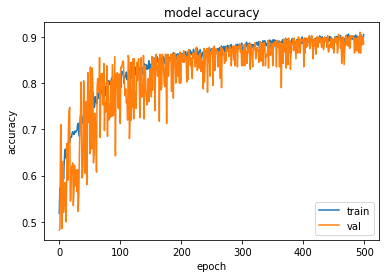

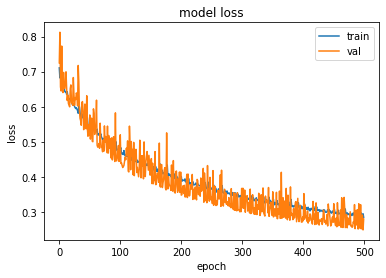

test accuracy: 0.86


In [9]:
model = sdl(768,2)

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(Z_train,y_train,batch_size=256,epochs=500,
          validation_split=0.1,verbose=0)
y_pred = np.argmax(model.predict(Z_test),axis=1)
history_plot(history)
print('test accuracy:',np.mean(y_test==y_pred))